# GNN example 

This notebook evaluates the Performance of different Graph-based models for the classification of the dataset, and plots Fig4.


In [ ]:
!pip install torch_geometric
!git clone https://github.com/Qulacs-Osaka/VQE-generated-dataset.git

In [ ]:
%cd VQE-generated-dataset/example
!python initialize_dataset.py

In [17]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.nn import BatchNorm1d
from torch.nn import Linear
from torch.nn.functional import relu, dropout
from torch.optim.lr_scheduler import StepLR
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.nn import SAGEConv

In [18]:
from accelerate import Accelerator

accelerator = Accelerator()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
import joblib

# Where to store the trained models
save_root_dir = "trained_data"
if not os.path.exists(save_root_dir):
    os.makedirs(save_root_dir)

In [21]:
# Set seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [22]:
# Replace with the actual number of qubits
num_qubits = 8

In [23]:
def load_and_shuffle_dataset():
    start_dir = f"./processed/{str(num_qubits).zfill(2)}_qubits"
    graphs = []
    for graph in os.listdir(start_dir):
        graphs.append(torch.load(start_dir + "/" + graph))
    random.shuffle(graphs)

    return graphs

In [24]:
# Load your dataset
graphs = load_and_shuffle_dataset()

# Determine the number of node features and classes
sample_graph = random.choice(graphs)
num_node_features = sample_graph.num_node_features
num_classes = len(set(graph.y for graph in graphs))

/var/folders/dg/vjh27h1x0klcm6hw2_gsywzr0000gn/T/ipykernel_17331/2474732561.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs.append(torch.load(start_dir + "/" + gr

In [25]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [26]:
def test(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset), total_loss / len(loader)

In [27]:
def check_early_stopping(val_acc, best_val_acc, train_acc, best_train_acc, early_stopping_counter, patience=30):
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_train_acc = train_acc
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > patience:
        print("Early stopping...")
        return True, best_val_acc, best_train_acc, early_stopping_counter

    return False, best_val_acc, best_train_acc, early_stopping_counter

In [28]:
def plot_training_validation_metrics(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc):
    """
    Plots the average training and validation loss and accuracy over epochs.
    
    """
    plt.figure(figsize=(10, 5))

    # Plotting average training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(avg_train_loss, label='Avg Training Loss')
    plt.plot(avg_val_loss, label='Avg Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Average Training and Validation Loss')
    plt.legend()

    # Plotting average training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(avg_train_acc, label='Avg Training Accuracy')
    plt.plot(avg_val_acc, label='Avg Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Average Training and Validation Accuracy')
    plt.legend()

    # Show the plot
    plt.show()


## 1. Training GCN

In [12]:
# 1. Load your dataset and shuffle
graphs = load_and_shuffle_dataset()

# 2. Determine the number of node features and classes
num_node_features = graphs[0].num_node_features
num_classes = len(set(graph.y for graph in graphs))

# 3. K-Fold Cross Validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

/var/folders/dg/vjh27h1x0klcm6hw2_gsywzr0000gn/T/ipykernel_17331/2468624989.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs.append(torch.load(start_dir + "/" + gr

In [13]:
# GCN: Graph Convolutional Network
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [16]:
# Training and validation for each fold
fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'best_val_acc': [],
    'best_train_acc': []
}
for fold, (train_idx, val_idx) in enumerate(kfold.split(graphs)):
    print(f"Fold {fold + 1}")

    # Split the training and validation data for the fold and set up a data loader.
    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]
    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=10, shuffle=False)

    # Reinitialize model and optimizer
    model = GCN(hidden_channels=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    training_losses = []
    validation_losses = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    best_train_acc = 0
    early_stopping_counter = 0

    # The model is trained at each epoch, and the loss and accuracy rates are calculated and stored. 
    for epoch in range(1, 300):
        train_loss = train(model, train_loader, optimizer, criterion)
        train_acc, _ = test(model, train_loader, criterion)
        val_acc, val_loss = test(model, val_loader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Check early stopping
        stop, best_val_acc, best_train_acc, early_stopping_counter = check_early_stopping(
            val_acc, best_val_acc, train_acc, best_train_acc, early_stopping_counter
        )
        if stop:
            break

        scheduler.step()

        if epoch % 10 == 0:
            print(
                f'Fold {fold + 1}, Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    fold_performance['train_loss'].append(training_losses)
    fold_performance['val_loss'].append(validation_losses)
    fold_performance['train_acc'].append(train_acc_history)
    fold_performance['val_acc'].append(val_acc_history)
    fold_performance['best_val_acc'].append(best_val_acc)
    fold_performance['best_train_acc'].append(best_train_acc)

    print(f"Completed Fold {fold + 1}")

# Find the minimum length across folds to trim the data
min_length = min(len(perf) for perf in fold_performance['train_loss'])

# 5. Compute average performance
avg_train_loss = np.mean([perf[:min_length] for perf in fold_performance['train_loss']], axis=0)
avg_val_loss = np.mean([perf[:min_length] for perf in fold_performance['val_loss']], axis=0)
avg_train_acc = np.mean([perf[:min_length] for perf in fold_performance['train_acc']], axis=0)
avg_val_acc = np.mean([perf[:min_length] for perf in fold_performance['val_acc']], axis=0)

Fold 1


/Users/nakayama/anaconda3/envs/hikari/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


KeyboardInterrupt: 

In [ ]:
plot_training_validation_metrics(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc)

In [ ]:
# Calculate the mean accuracy for training and validation
mean_train_acc = np.mean(fold_performance['best_train_acc'])
mean_val_acc = np.mean(fold_performance['best_val_acc'])
acc_data = {
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc}

# Define model name and file name
model_name = model.__class__.__name__
acc_filename = f"{save_root_dir}/{str(num_qubits).zfill(2)}_qubits_{model_name}_final_accuracies.jb"
model_filename = f"{save_root_dir}/{str(num_qubits).zfill(2)}_qubits_{model_name}_final_model.jb"

# Save the model parameters
joblib.dump(model.state_dict(), model_filename)
print(f"Model parameters saved to {model_filename}")

# Save accuracies
joblib.dump(acc_data, acc_filename)
print(f"Accuracies saved to {acc_filename}")

# Loading the accuracies (for verification)
loaded_acc_data = joblib.load(acc_filename)
print("Loaded Mean Training Accuracy:", loaded_acc_data['mean_train_acc'])
print("Loaded Mean Validation Accuracy:", loaded_acc_data['mean_val_acc'])

## 2. Training GCN v2

TODO: パラメータ数が多い、など、説明を加える。

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# 1. Load your dataset and shuffle
graphs = load_and_shuffle_dataset()

# 2. Determine the number of node features and classes
num_node_features = graphs[0].num_node_features
num_classes = len(set(graph.y for graph in graphs))

# 3. K-Fold Cross Validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
class ImprovedGCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(ImprovedGCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)  # Assuming 5 classes

    def forward(self, x, edge_index, batch):
        x = relu(self.bn1(self.conv1(x, edge_index)))
        x = relu(self.bn2(self.conv2(x, edge_index)))
        x = self.bn3(self.conv3(x, edge_index))

        x = global_mean_pool(x, batch)

        x = dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [ ]:
# Training and validation for each fold
fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'best_val_acc': [],
    'best_train_acc': []
}
for fold, (train_idx, val_idx) in enumerate(kfold.split(graphs)):
    print(f"Fold {fold + 1}")

    # Split the training and validation data for the fold and set up a data loader.
    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]
    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=10, shuffle=False)

    # Reinitialize model and optimizer
    model = ImprovedGCN(hidden_channels=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    training_losses = []
    validation_losses = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    best_train_acc = 0
    early_stopping_counter = 0

    # The model is trained at each epoch, and the loss and accuracy rates are calculated and stored. 
    for epoch in range(1, 300):
        train_loss = train(model, train_loader, optimizer, criterion)
        train_acc, _ = test(model, train_loader, criterion)
        val_acc, val_loss = test(model, val_loader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Check early stopping
        stop, best_val_acc, best_train_acc, early_stopping_counter = check_early_stopping(
            val_acc, best_val_acc, train_acc, best_train_acc, early_stopping_counter
        )
        if stop:
            break

        scheduler.step()

        if epoch % 10 == 0:
            print(
                f'Fold {fold + 1}, Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    fold_performance['train_loss'].append(training_losses)
    fold_performance['val_loss'].append(validation_losses)
    fold_performance['train_acc'].append(train_acc_history)
    fold_performance['val_acc'].append(val_acc_history)
    fold_performance['best_val_acc'].append(best_val_acc)
    fold_performance['best_train_acc'].append(best_train_acc)

    print(f"Completed Fold {fold + 1}")

# Find the minimum length across folds to trim the data
min_length = min(len(perf) for perf in fold_performance['train_loss'])

# 5. Compute average performance
avg_train_loss = np.mean([perf[:min_length] for perf in fold_performance['train_loss']], axis=0)
avg_val_loss = np.mean([perf[:min_length] for perf in fold_performance['val_loss']], axis=0)
avg_train_acc = np.mean([perf[:min_length] for perf in fold_performance['train_acc']], axis=0)
avg_val_acc = np.mean([perf[:min_length] for perf in fold_performance['val_acc']], axis=0)

In [ ]:
plot_training_validation_metrics(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc)

Fold 1
Fold 1, Epoch 10, Train Loss: 1.759234509865443, Train Acc: 0.2475, Val Loss: 1.7469205617904664, Val Acc: 0.15833333333333333
Fold 1, Epoch 20, Train Loss: 1.7353033989667892, Train Acc: 0.2425, Val Loss: 1.7263743241628011, Val Acc: 0.16
Fold 1, Epoch 30, Train Loss: 1.7440516432126363, Train Acc: 0.2708333333333333, Val Loss: 1.7293828030427296, Val Acc: 0.20166666666666666
Fold 1, Epoch 40, Train Loss: 1.723169818520546, Train Acc: 0.2675, Val Loss: 1.7292146503925323, Val Acc: 0.20833333333333334
Fold 1, Epoch 50, Train Loss: 1.718941115339597, Train Acc: 0.2841666666666667, Val Loss: 1.7226727724075317, Val Acc: 0.21333333333333335
Fold 1, Epoch 60, Train Loss: 1.7028559356927873, Train Acc: 0.2833333333333333, Val Loss: 1.715473759174347, Val Acc: 0.20166666666666666
Fold 1, Epoch 70, Train Loss: 1.7097061157226563, Train Acc: 0.2833333333333333, Val Loss: 1.7140769461790721, Val Acc: 0.21833333333333332
Fold 1, Epoch 80, Train Loss: 1.710791144768397, Train Acc: 0.2925, 

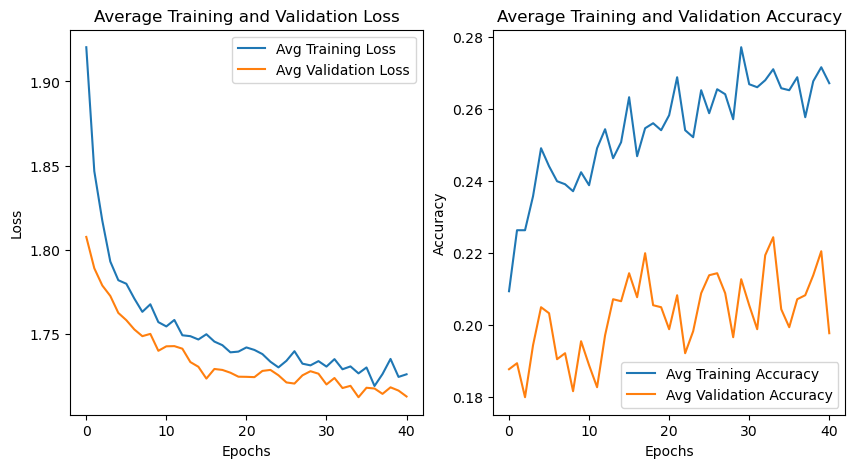

Model parameters saved to k_fold8qubits_ImprovedGCN_final_model.pkl
Accuracies saved to k_fold/8qubits_ImprovedGCN_final_accuracies.npy
Loaded Mean Training Accuracy: 0.26805555555555555
Loaded Mean Validation Accuracy: 0.24055555555555555


In [9]:
# Calculate the mean accuracy for training and validation
mean_train_acc = np.mean(fold_performance['best_train_acc'])
mean_val_acc = np.mean(fold_performance['best_val_acc'])
acc_data = {
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc}

# Define model name and file name
model_name = model.__class__.__name__
acc_filename = f"{save_root_dir}/{str(num_qubits).zfill(2)}_qubits_{model_name}_final_accuracies.jb"
model_filename = f"{save_root_dir}/{str(num_qubits).zfill(2)}_qubits_{model_name}_final_model.jb"

# Save the model parameters
joblib.dump(model.state_dict(), model_filename)
print(f"Model parameters saved to {model_filename}")

# Save accuracies
joblib.dump(acc_data, acc_filename)
print(f"Accuracies saved to {acc_filename}")

# Loading the accuracies (for verification)
loaded_acc_data = joblib.load(acc_filename)
print("Loaded Mean Training Accuracy:", loaded_acc_data['mean_train_acc'])
print("Loaded Mean Validation Accuracy:", loaded_acc_data['mean_val_acc'])

## 3. Training GIN

In [ ]:
# 1. Load your dataset and shuffle
graphs = load_and_shuffle_dataset()

# 2. Determine the number of node features and classes
num_node_features = graphs[0].num_node_features
num_classes = len(set(graph.y for graph in graphs))

# 3. K-Fold Cross Validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
class GINModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GINModel, self).__init__()
        nn1 = torch.nn.Sequential(Linear(num_node_features, 64), torch.nn.ReLU(), Linear(64, 64))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(64)

        nn2 = torch.nn.Sequential(Linear(64, 64), torch.nn.ReLU(), Linear(64, 64))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(64)

        self.lin = Linear(64, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)

        x = global_add_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=-1)

In [ ]:
# Training and validation for each fold
fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'best_val_acc': [],
    'best_train_acc': []
}
for fold, (train_idx, val_idx) in enumerate(kfold.split(graphs)):
    print(f"Fold {fold + 1}")

    # Split the training and validation data for the fold and set up a data loader.
    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]
    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=10, shuffle=False)

    # Reinitialize model and optimizer
    model = GINModel(num_node_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    training_losses = []
    validation_losses = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    best_train_acc = 0
    early_stopping_counter = 0

    # The model is trained at each epoch, and the loss and accuracy rates are calculated and stored. 
    for epoch in range(1, 300):
        train_loss = train(model, train_loader, optimizer, criterion)
        train_acc, _ = test(model, train_loader, criterion)
        val_acc, val_loss = test(model, val_loader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Check early stopping
        stop, best_val_acc, best_train_acc, early_stopping_counter = check_early_stopping(
            val_acc, best_val_acc, train_acc, best_train_acc, early_stopping_counter, patience=40)
        if stop:
            break

        scheduler.step()

        if epoch % 10 == 0:
            print(
                f'Fold {fold + 1}, Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    fold_performance['train_loss'].append(training_losses)
    fold_performance['val_loss'].append(validation_losses)
    fold_performance['train_acc'].append(train_acc_history)
    fold_performance['val_acc'].append(val_acc_history)
    fold_performance['best_val_acc'].append(best_val_acc)
    fold_performance['best_train_acc'].append(best_train_acc)

    print(f"Completed Fold {fold + 1}")

# Find the minimum length across folds to trim the data
min_length = min(len(perf) for perf in fold_performance['train_loss'])

# 5. Compute average performance
avg_train_loss = np.mean([perf[:min_length] for perf in fold_performance['train_loss']], axis=0)
avg_val_loss = np.mean([perf[:min_length] for perf in fold_performance['val_loss']], axis=0)
avg_train_acc = np.mean([perf[:min_length] for perf in fold_performance['train_acc']], axis=0)
avg_val_acc = np.mean([perf[:min_length] for perf in fold_performance['val_acc']], axis=0)

In [ ]:
plot_training_validation_metrics(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc)

In [ ]:
# Calculate the mean accuracy for training and validation
mean_train_acc = np.mean(fold_performance['best_train_acc'])
mean_val_acc = np.mean(fold_performance['best_val_acc'])
acc_data = {
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc}

# Define model name and file name
model_name = model.__class__.__name__
acc_filename = f"{save_root_dir}/{str(num_qubits).zfill(2)}_qubits_{model_name}_final_accuracies.jb"
model_filename = f"{save_root_dir}/{str(num_qubits).zfill(2)}_qubits_{model_name}_final_model.jb"

# Save the model parameters
joblib.dump(model.state_dict(), model_filename)
print(f"Model parameters saved to {model_filename}")

# Save accuracies
joblib.dump(acc_data, acc_filename)
print(f"Accuracies saved to {acc_filename}")

# Loading the accuracies (for verification)
loaded_acc_data = joblib.load(acc_filename)
print("Loaded Mean Training Accuracy:", loaded_acc_data['mean_train_acc'])
print("Loaded Mean Validation Accuracy:", loaded_acc_data['mean_val_acc'])

## 4. Training GAT

In [ ]:
# 1. Load your dataset and shuffle
graphs = load_and_shuffle_dataset()

# 2. Determine the number of node features and classes
num_node_features = graphs[0].num_node_features
num_classes = len(set(graph.y for graph in graphs))

# 3. K-Fold Cross Validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [12]:
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, 64, heads=8, dropout=0.6)
        self.conv2 = GATConv(64 * 8, 128, heads=1, concat=False, dropout=0.6)
        self.out = Linear(128, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)

        return F.log_softmax(self.out(x), dim=1)

In [ ]:
# Training and validation for each fold
fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'best_val_acc': [],
    'best_train_acc': []
}
for fold, (train_idx, val_idx) in enumerate(kfold.split(graphs)):
    print(f"Fold {fold + 1}")

    # Split the training and validation data for the fold and set up a data loader.
    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]
    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=10, shuffle=False)

    # Reinitialize model and optimizer
    model = GAT(num_node_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    training_losses = []
    validation_losses = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    best_train_acc = 0
    early_stopping_counter = 0

    # The model is trained at each epoch, and the loss and accuracy rates are calculated and stored. 
    for epoch in range(1, 300):
        train_loss = train(model, train_loader, optimizer, criterion)
        train_acc, _ = test(model, train_loader, criterion)
        val_acc, val_loss = test(model, val_loader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Check early stopping
        stop, best_val_acc, best_train_acc, early_stopping_counter = check_early_stopping(
            val_acc, best_val_acc, train_acc, best_train_acc, early_stopping_counter
        )
        if stop:
            break

        scheduler.step()

        if epoch % 10 == 0:
            print(
                f'Fold {fold + 1}, Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    fold_performance['train_loss'].append(training_losses)
    fold_performance['val_loss'].append(validation_losses)
    fold_performance['train_acc'].append(train_acc_history)
    fold_performance['val_acc'].append(val_acc_history)
    fold_performance['best_val_acc'].append(best_val_acc)
    fold_performance['best_train_acc'].append(best_train_acc)

    print(f"Completed Fold {fold + 1}")

# Find the minimum length across folds to trim the data
min_length = min(len(perf) for perf in fold_performance['train_loss'])

# 5. Compute average performance
avg_train_loss = np.mean([perf[:min_length] for perf in fold_performance['train_loss']], axis=0)
avg_val_loss = np.mean([perf[:min_length] for perf in fold_performance['val_loss']], axis=0)
avg_train_acc = np.mean([perf[:min_length] for perf in fold_performance['train_acc']], axis=0)
avg_val_acc = np.mean([perf[:min_length] for perf in fold_performance['val_acc']], axis=0)

In [ ]:
plot_training_validation_metrics(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc)

In [ ]:
# Calculate the mean accuracy for training and validation
mean_train_acc = np.mean(fold_performance['best_train_acc'])
mean_val_acc = np.mean(fold_performance['best_val_acc'])
acc_data = {
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc}

# Define model name and file name
model_name = model.__class__.__name__
acc_filename = f"{save_root_dir}/{str(num_qubits).zfill(2)}_qubits_{model_name}_final_accuracies.jb"
model_filename = f"{save_root_dir}/{str(num_qubits).zfill(2)}_qubits_{model_name}_final_model.jb"

# Save the model parameters
joblib.dump(model.state_dict(), model_filename)
print(f"Model parameters saved to {model_filename}")

# Save accuracies
joblib.dump(acc_data, acc_filename)
print(f"Accuracies saved to {acc_filename}")

# Loading the accuracies (for verification)
loaded_acc_data = joblib.load(acc_filename)
print("Loaded Mean Training Accuracy:", loaded_acc_data['mean_train_acc'])
print("Loaded Mean Validation Accuracy:", loaded_acc_data['mean_val_acc'])

## 5. Training GraphSAGE

In [ ]:
# 1. Load your dataset and shuffle
graphs = load_and_shuffle_dataset()

# 2. Determine the number of node features and classes
num_node_features = graphs[0].num_node_features
num_classes = len(set(graph.y for graph in graphs))

# 3. K-Fold Cross Validation setup
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_node_features, 64)
        self.conv2 = SAGEConv(64, 128)
        self.out = Linear(128, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)

        return F.log_softmax(self.out(x), dim=1)

In [ ]:
# Training and validation for each fold
fold_performance = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'best_val_acc': [],
    'best_train_acc': []
}
for fold, (train_idx, val_idx) in enumerate(kfold.split(graphs)):
    print(f"Fold {fold + 1}")

    # Split the training and validation data for the fold and set up a data loader.
    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]
    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=10, shuffle=False)

    # Reinitialize model and optimizer
    model = GraphSAGE(num_node_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    training_losses = []
    validation_losses = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0
    best_train_acc = 0
    early_stopping_counter = 0

    # The model is trained at each epoch, and the loss and accuracy rates are calculated and stored. 
    for epoch in range(1, 300):
        train_loss = train(model, train_loader, optimizer, criterion)
        train_acc, _ = test(model, train_loader, criterion)
        val_acc, val_loss = test(model, val_loader, criterion)

        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Check early stopping
        stop, best_val_acc, best_train_acc, early_stopping_counter = check_early_stopping(
            val_acc, best_val_acc, train_acc, best_train_acc, early_stopping_counter
        )
        if stop:
            break

        scheduler.step()

        if epoch % 10 == 0:
            print(
                f'Fold {fold + 1}, Epoch {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    fold_performance['train_loss'].append(training_losses)
    fold_performance['val_loss'].append(validation_losses)
    fold_performance['train_acc'].append(train_acc_history)
    fold_performance['val_acc'].append(val_acc_history)
    fold_performance['best_val_acc'].append(best_val_acc)
    fold_performance['best_train_acc'].append(best_train_acc)

    print(f"Completed Fold {fold + 1}")

# Find the minimum length across folds to trim the data
min_length = min(len(perf) for perf in fold_performance['train_loss'])

# 5. Compute average performance
avg_train_loss = np.mean([perf[:min_length] for perf in fold_performance['train_loss']], axis=0)
avg_val_loss = np.mean([perf[:min_length] for perf in fold_performance['val_loss']], axis=0)
avg_train_acc = np.mean([perf[:min_length] for perf in fold_performance['train_acc']], axis=0)
avg_val_acc = np.mean([perf[:min_length] for perf in fold_performance['val_acc']], axis=0)

In [ ]:
plot_training_validation_metrics(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc)

In [ ]:
# Calculate the mean accuracy for training and validation
mean_train_acc = np.mean(fold_performance['best_train_acc'])
mean_val_acc = np.mean(fold_performance['best_val_acc'])
acc_data = {
    'mean_train_acc': mean_train_acc,
    'mean_val_acc': mean_val_acc}

# Define model name and file name
model_name = model.__class__.__name__
acc_filename = f"{save_root_dir}/{str(num_qubits).zfill(2)}_qubits_{model_name}_final_accuracies.jb"
model_filename = f"{save_root_dir}/{str(num_qubits).zfill(2)}_qubits_{model_name}_final_model.jb"

# Save the model parameters
joblib.dump(model.state_dict(), model_filename)
print(f"Model parameters saved to {model_filename}")

# Save accuracies
joblib.dump(acc_data, acc_filename)
print(f"Accuracies saved to {acc_filename}")

# Loading the accuracies (for verification)
loaded_acc_data = joblib.load(acc_filename)
print("Loaded Mean Training Accuracy:", loaded_acc_data['mean_train_acc'])
print("Loaded Mean Validation Accuracy:", loaded_acc_data['mean_val_acc'])

# Plotting

By running the above cells from 4 qubits to 16 qubits, you can plot Fig.4

In [102]:
import glob

acc_datas_dict = {}
model_names = ["GAT", "GCN", "GINModel", "GraphSAGE", "ImprovedGCN"]

for model_name in model_names:
    x_list = []
    y_list = []
    for n_qubits in [4, 8, 12, 16, 20]:
        file_names = glob.glob(f"./trained_data/{str(n_qubits).zfill(2)}_qubits_{model_name}_final_accuracies.jb")
        if len(file_names) != 1:
            assert False, "something is wrong"
        acc_data = joblib.load(file_names[0])
        x_list.append(n_qubits)
        y_list.append(acc_data['mean_val_acc'])
    acc_datas_dict[model_name] = {"x": x_list, "y": y_list}

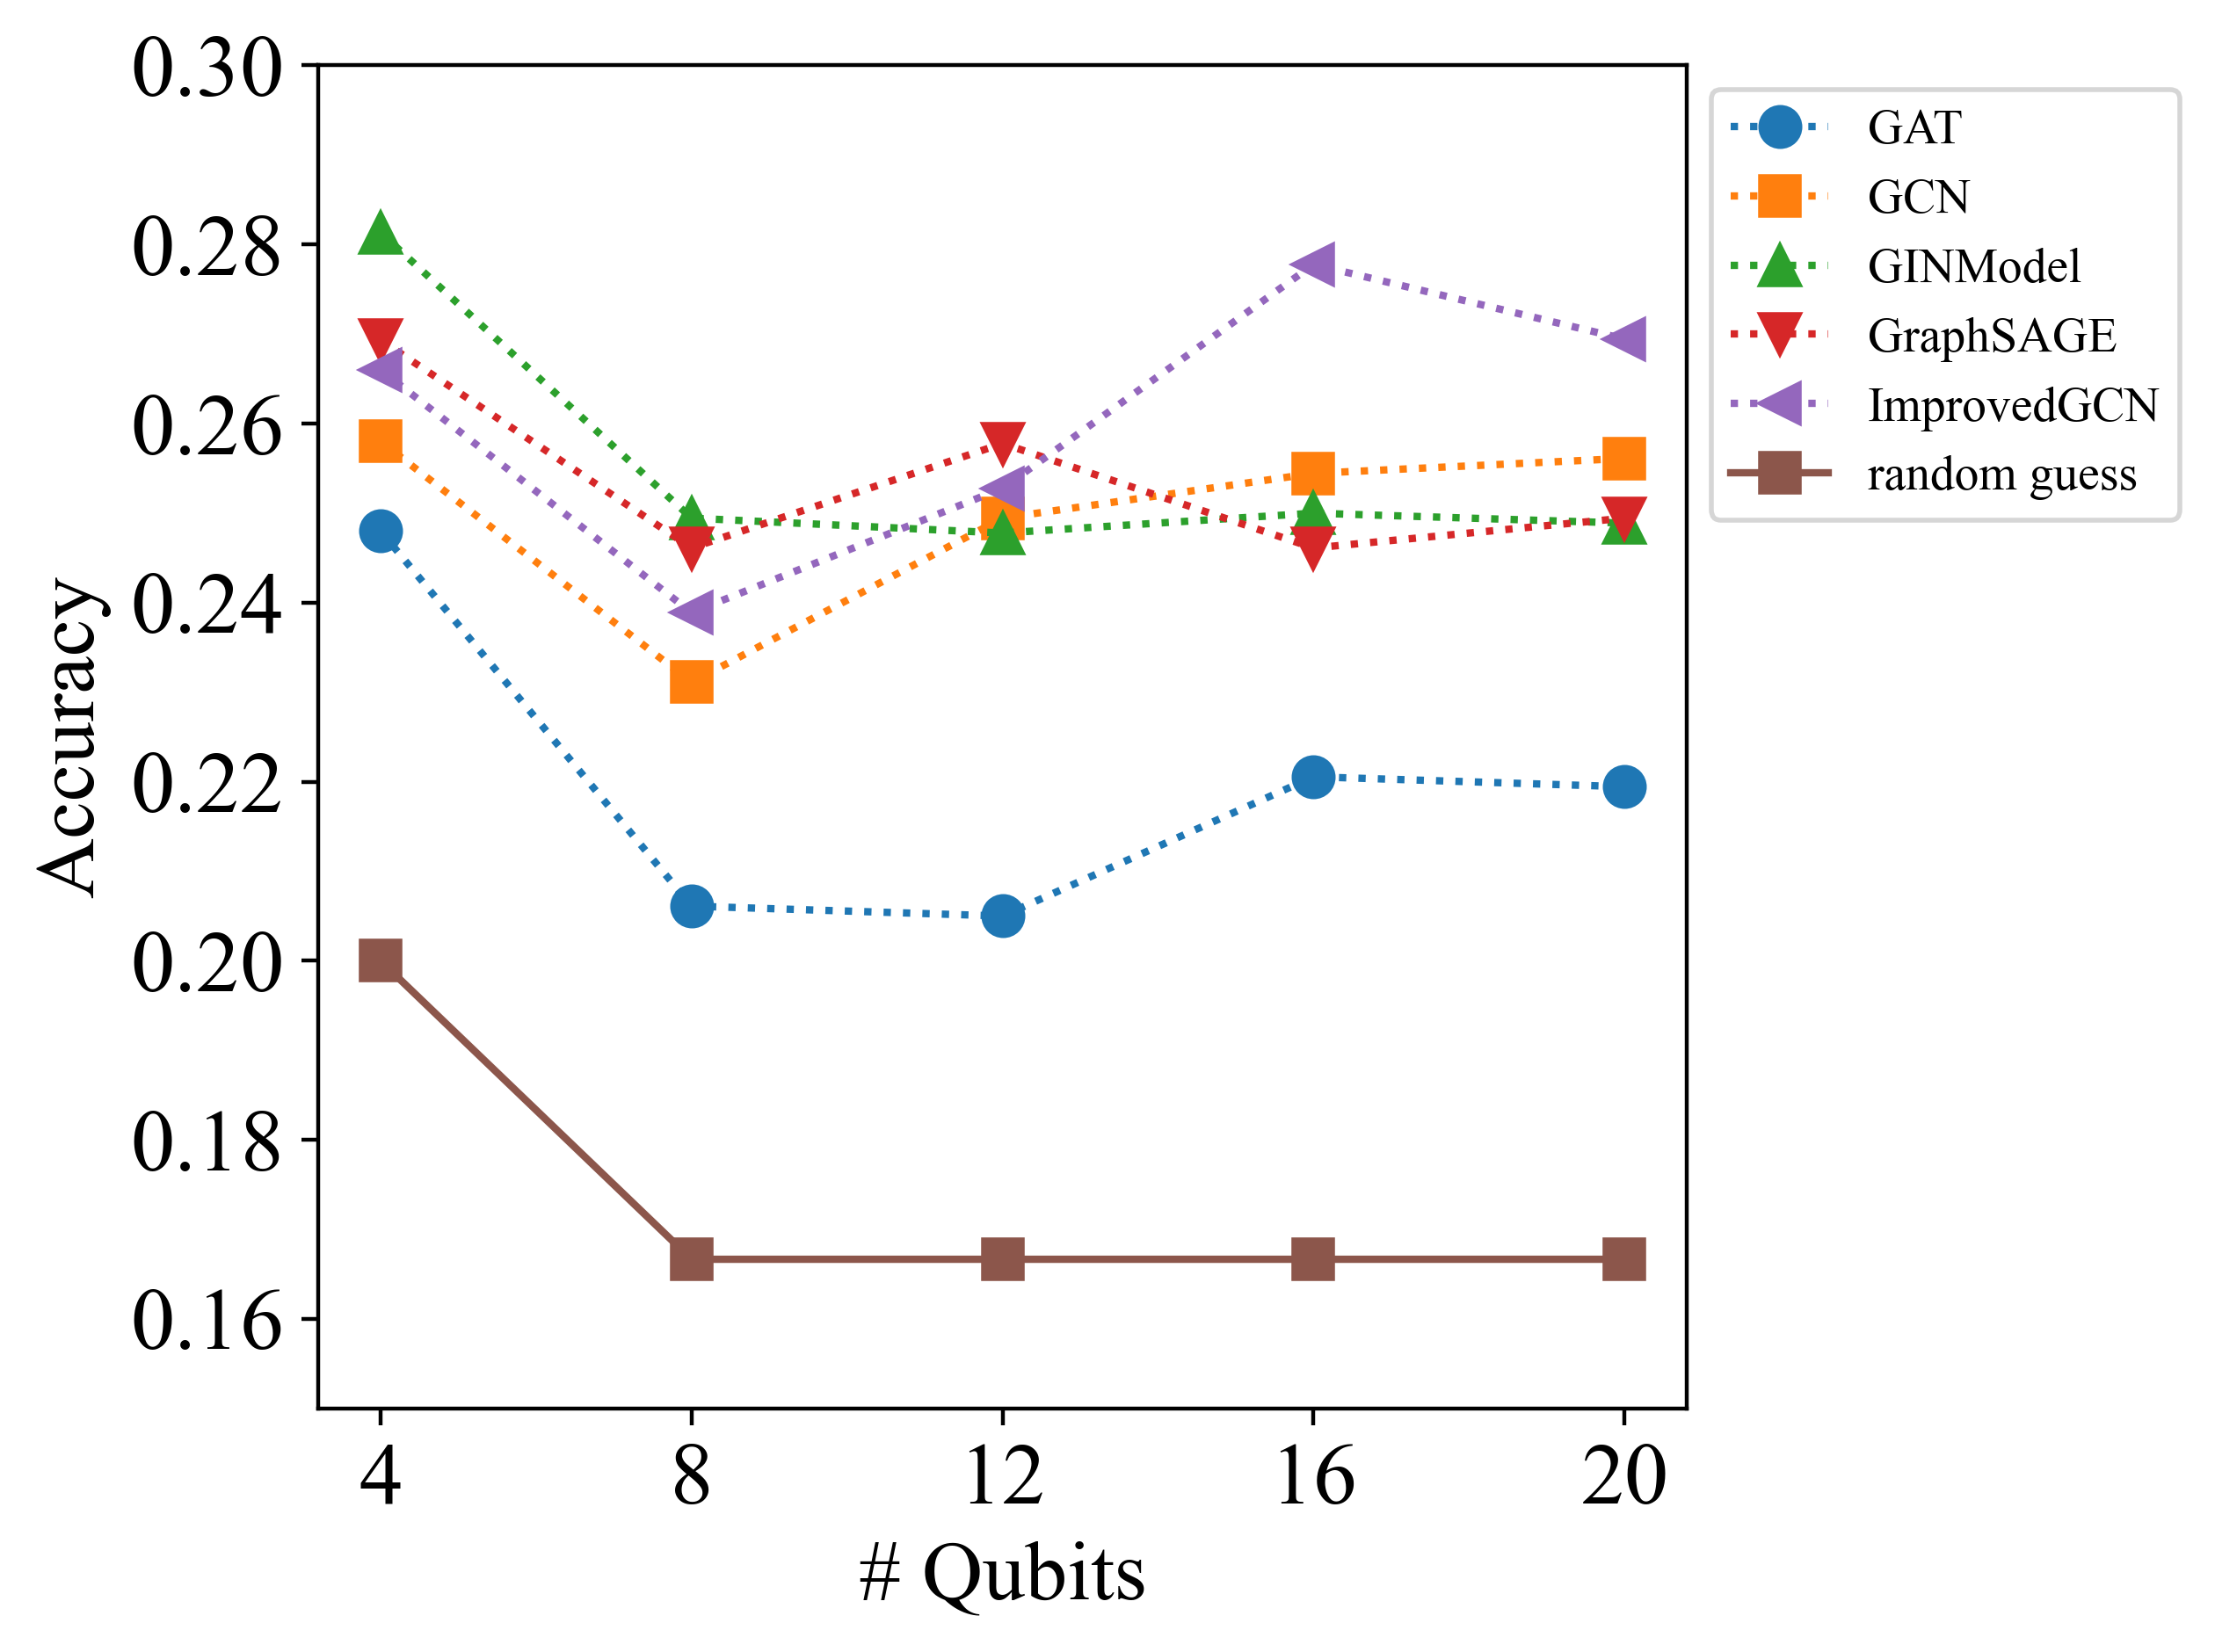

In [103]:
markers = ["o", "s", "^", "v", "<", ">", "1", "+", "x", "D"]
plt.rcParams['font.family'] = 'times new roman'

fig, ax = plt.subplots(dpi=400)
ax.set_xlabel("# Qubits", size="xx-large")
ax.set_ylabel("Accuracy", size="xx-large")
ax.tick_params(axis='both', labelsize=18)
ax.set_yticks(np.arange(0.14, 0.31, 0.02))  # 0から1まで0.02刻み
ax.set_xticks(np.arange(4, 24, 4))
ax.grid(False)

for i, model_name in enumerate(model_names):
    ax.plot(acc_datas_dict[model_name]["x"], acc_datas_dict[model_name]["y"], ":", label=model_name, marker=markers[i],
            markersize=8)
ax.plot([4, 8, 12, 16, 20], [0.2] * 1 + [1 / 6] * 4, "-s", label=f"random guess", markersize=8)
ax.set_ylim(0.15, 0.3)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("../doc/image/fig4.pdf", dpi=400)
